In [264]:
#  install required libraries
#!pip install librosa numpy scikit-learn matplotlib seaborn imbalanced-learn xgboost tensorflow pandas

In [265]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,Flatten,SimpleRNN,Conv1D, MaxPooling1D
import pandas as pd
from tensorflow.keras.models import Model
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [266]:
# Dataset Path
data_path = 'D:/NCI/Sem 3/Thesis/code_DB/dataset'

In [267]:
#classes
class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

# Initialize lists to hold features and labels
X = []
y = []

# Parameters for feature extraction
n_mfcc = 13  # Number of MFCC features to extract
n_chroma = 12  # Number of chroma features
n_spectral_contrast = 7  # Number of spectral contrast features
max_pad_len = 174  # Ensure all audio files have the same length


In [268]:
results_df = pd.DataFrame(columns=['Model', 'Accuracy','F1 Score','Precision','Recall'])

In [269]:
def extract_mfcc(file_path):
    """Extract MFCC features from a given audio file."""
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    # Pad or truncate the MFCCs to a fixed length
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    return mfccs

In [270]:
# Loop through each class folder and extract MFCCs
for i, label in enumerate(class_labels):
    folder_path = os.path.join(data_path, label)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            mfcc = extract_mfcc(file_path)
            X.append(mfcc)
            y.append(i)  # Store the class label as an integer

In [271]:
# Convert to numpy arrays
X_mfcc = np.array(X)
y_mfcc = np.array(y)
X1 = X_mfcc
y1 = y_mfcc

In [272]:
X1.shape

(457, 13, 174)

In [273]:
# Reshape X to be suitable for the SVM
X_mfcc = X_mfcc.reshape(X_mfcc.shape[0], -1)  # Flatten the MFCC array

In [274]:
print(f'Extracted {X_mfcc.shape[0]} samples with shape {X_mfcc.shape}')

Extracted 457 samples with shape (457, 2262)


## Simple models with original data

In [275]:
#Split the data into training and test sets
X_mfcc_train, X_mfcc_test, y_mfcc_train, y_mfcc_test = train_test_split(X_mfcc, y_mfcc, test_size=0.2, random_state=42)

1. SVM model Simple

In [276]:
# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)

In [277]:
# Define a list of scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted')
}



In [278]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(svm_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [279]:
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["SVM (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df



5-Fold Cross-Validation Accuracy: 0.77
5-Fold Cross-Validation F1_weighted: 0.75
5-Fold Cross-Validation Precision_weighted: 0.73
5-Fold Cross-Validation Recall_weighted: 0.77


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123


In [280]:
# Refit the model with the training data for confusion matrix and report
svm_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = svm_model.predict(X_mfcc_test)

# Print classification report
#class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']  #  class names
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))




              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.25      0.14      0.18         7
      hungry       0.81      0.85      0.83        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.67        92
   macro avg       0.21      0.20      0.20        92
weighted avg       0.66      0.67      0.66        92



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

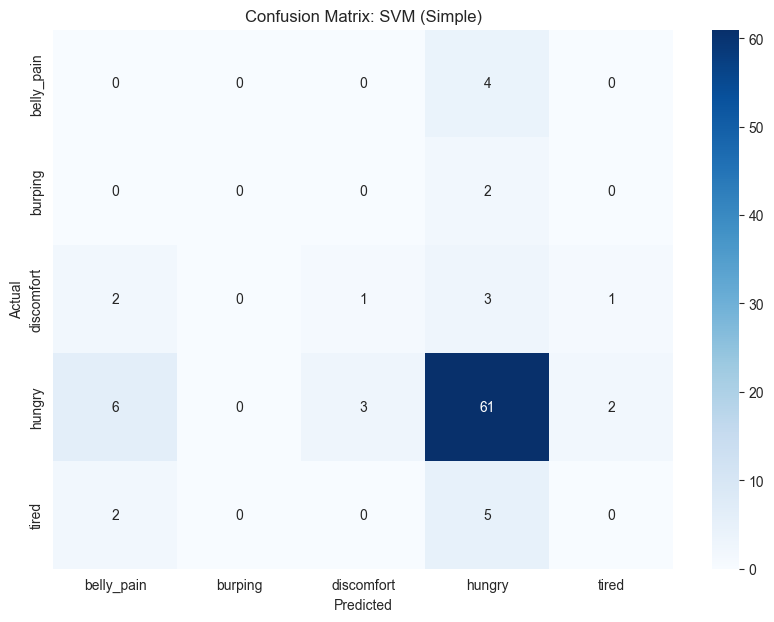

In [281]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: SVM (Simple)')
plt.show()

2. KNN-Simple

In [282]:
# Step 1: Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors based on your analysis

# Step 2: Define scoring metrics for cross-validation
'''scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted')
}'''

# Step 3: Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(knn_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

# Step 4: Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["KNN (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

5-Fold Cross-Validation Accuracy: 0.84
5-Fold Cross-Validation F1_weighted: 0.77
5-Fold Cross-Validation Precision_weighted: 0.72
5-Fold Cross-Validation Recall_weighted: 0.84


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      0.99      0.87        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.77        92
   macro avg       0.16      0.20      0.17        92
weighted avg       0.61      0.77      0.68        92



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

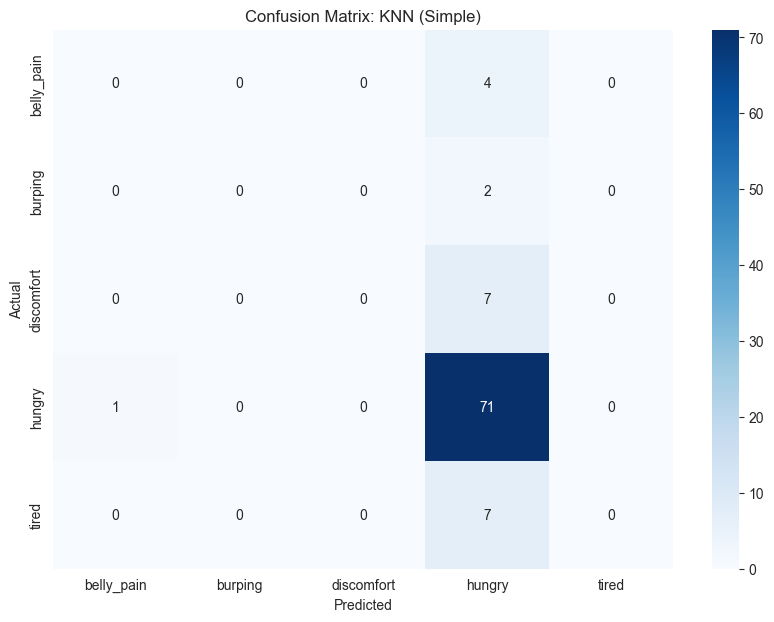

In [283]:
# Refit the model with the training data for confusion matrix and report
knn_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = knn_model.predict(X_mfcc_test)

# Print classification report
#class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']  #  class names
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: KNN (Simple)')
plt.show()

3. Random Forest (Simple)

In [284]:
# Random Forest

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [285]:
# Step 3: Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(rf_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [286]:
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 0.85
5-Fold Cross-Validation F1_weighted: 0.78
5-Fold Cross-Validation Precision_weighted: 0.72
5-Fold Cross-Validation Recall_weighted: 0.85


In [287]:
# Step : Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["Random Forest (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315


D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      1.00      0.88        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.78        92
   macro avg       0.16      0.20      0.18        92
weighted avg       0.61      0.78      0.69        92



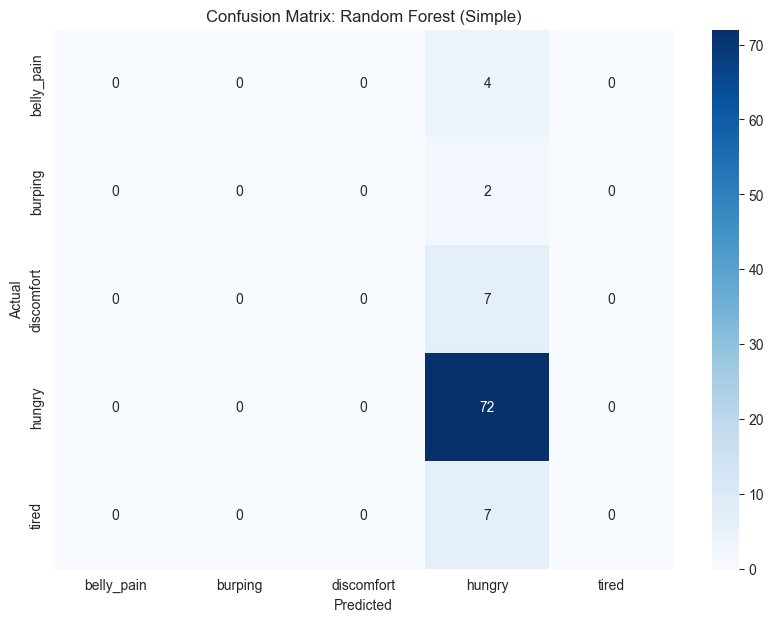

In [288]:
# Refit the model with the training data for confusion matrix and report
rf_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = rf_model.predict(X_mfcc_test)

# Print classification report
#class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']  #  class names
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Random Forest (Simple)')
plt.show()

4. AdaBoost model

In [289]:
# Initializing the AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

In [290]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(ada_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [291]:
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 0.76
5-Fold Cross-Validation F1_weighted: 0.74
5-Fold Cross-Validation Precision_weighted: 0.74
5-Fold Cross-Validation Recall_weighted: 0.76


In [292]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["AdaBoost (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904


In [293]:
'''results_df=results_df.iloc[:-1]
results_df #delete last row'''

'results_df=results_df.iloc[:-1]\nresults_df #delete last row'

In [294]:
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904


D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      0.96      0.86        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.75        92
   macro avg       0.16      0.19      0.17        92
weighted avg       0.61      0.75      0.68        92



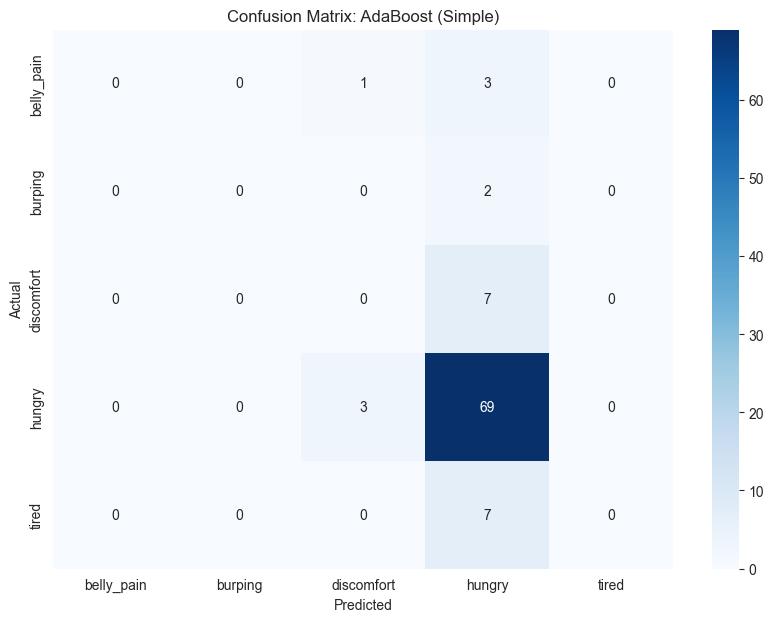

In [295]:
# Refit the model with the training data for confusion matrix and report
ada_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = ada_model.predict(X_mfcc_test)

# Print classification report
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: AdaBoost (Simple)')
plt.show()

5. XGBoost Model

In [296]:
# Initializing the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [297]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(xgb_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:37:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Par

5-Fold Cross-Validation Accuracy: 0.84
5-Fold Cross-Validation F1_weighted: 0.78
5-Fold Cross-Validation Precision_weighted: 0.72
5-Fold Cross-Validation Recall_weighted: 0.84


In [298]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["XGBoost (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836


D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:40:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      1.00      0.88        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.78        92
   macro avg       0.16      0.20      0.18        92
weighted avg       0.61      0.78      0.69        92



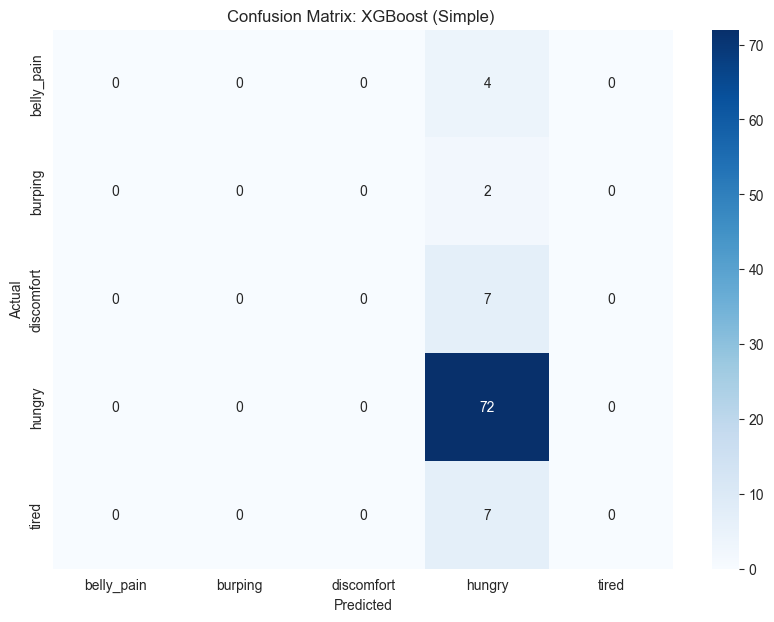

In [299]:
# Refit the model with the training data for confusion matrix and report
xgb_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = xgb_model.predict(X_mfcc_test)

# Print classification report
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: XGBoost (Simple) ')
plt.show()

6. LSTM

In [300]:
# Reshape X for LSTM (samples, time_steps, features)
X_lstm = X1.reshape(X1.shape[0], X1.shape[2], X1.shape[1])  


In [301]:
# One-hot encode labels
y_lstm = to_categorical(y1, num_classes=len(class_labels))

In [302]:
y_lstm.shape

(457, 5)

In [303]:
# Split the data into train and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42, stratify=y1)

In [304]:
y_test_lstm.shape

(138, 5)

In [305]:
y_train_lstm.shape

(319, 5)

In [306]:
# Define the LSTM model
lstm_model = Sequential()
# Add LSTM layer
lstm_model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.3))
# Add another LSTM layer
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.3))
# Add Dense layers
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.3))
# Output layer with softmax for multi-class classification
lstm_model.add(Dense(len(class_labels), activation='softmax'))
# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/50
10/10 [==============================] - 10s 528ms/step - loss: 1.3347 - accuracy: 0.5549 - val_loss: 0.7869 - val_accuracy: 0.8333
Epoch 2/50
10/10 [==============================] - 4s 403ms/step - loss: 0.8135 - accuracy: 0.8245 - val_loss: 0.6917 - val_accuracy: 0.8333
Epoch 3/50
10/10 [==============================] - 3s 300ms/step - loss: 0.7519 - accuracy: 0.8276 - val_loss: 0.6818 - val_accuracy: 0.8333
Epoch 4/50
10/10 [==============================] - 3s 299ms/step - loss: 0.7410 - accuracy: 0.8307 - val_loss: 0.6783 - val_accuracy: 0.8333
Epoch 5/50
10/10 [==============================] - 3s 301ms/step - loss: 0.7226 - accuracy: 0.8339 - val_loss: 0.6788 - val_accuracy: 0.8333
Epoch 6/50
10/10 [==============================] - 3s 294ms/step - loss: 0.6947 - accuracy: 0.8370 - val_loss: 0.6773 - val_accuracy: 0.8333
Epoch 7/50
10/10 [==============================] - 3s 312ms/step - loss: 0.6660 - accuracy: 0.8401 - val_loss: 0.6869 - val_accuracy: 0.8333
Epoch

In [307]:
# Evaluate the model
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
y_test_lstm_ = np.argmax(y_test_lstm, axis=1)

5/5 [==============================] - 2s 69ms/step


In [308]:
# Accuracy
accuracy = accuracy_score(y_test_lstm_, y_pred_lstm)
f1 = f1_score(y_test_lstm_, y_pred_lstm, average='weighted')
precision = precision_score(y_test_lstm_, y_pred_lstm, average='weighted')
recall = recall_score(y_test_lstm_, y_pred_lstm, average='weighted')

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [309]:
new_row_cv = pd.DataFrame([["LSTM", accuracy , f1, precision,recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
'''
new_row_cv = pd.DataFrame([["LSTM", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])'''
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         5
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         8
      hungry       0.84      0.95      0.89       115
       tired       0.00      0.00      0.00         7

    accuracy                           0.79       138
   macro avg       0.17      0.19      0.18       138
weighted avg       0.70      0.79      0.74       138



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

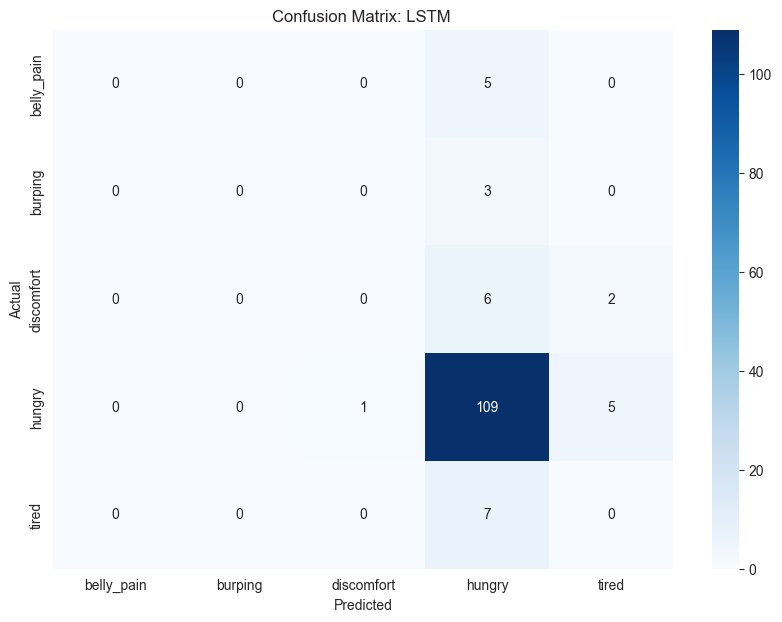

In [310]:
# Classification report
print(classification_report(y_test_lstm_, y_pred_lstm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_lstm_, y_pred_lstm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: LSTM ')
plt.show()

7. RNN

In [311]:
# Split the data into train and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42, stratify=y1)

In [312]:
# Define the RNN model
rnn_model = Sequential()

In [313]:
# Add SimpleRNN layer
rnn_model.add(SimpleRNN(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
rnn_model.add(Dropout(0.3))

In [314]:
# Add another SimpleRNN layer
rnn_model.add(SimpleRNN(64, return_sequences=False))
rnn_model.add(Dropout(0.3))



In [315]:
# Add Dense layers
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dropout(0.3))
# Output layer with softmax for multi-class classification
rnn_model.add(Dense(len(class_labels), activation='softmax'))
# Compile the model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [316]:
# Train the model
history = rnn_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/50
10/10 [==============================] - 5s 209ms/step - loss: 1.7940 - accuracy: 0.2696 - val_loss: 1.2454 - val_accuracy: 0.5435
Epoch 2/50
10/10 [==============================] - 1s 101ms/step - loss: 1.3467 - accuracy: 0.5141 - val_loss: 1.0395 - val_accuracy: 0.6232
Epoch 3/50
10/10 [==============================] - 1s 98ms/step - loss: 1.1658 - accuracy: 0.5705 - val_loss: 0.9071 - val_accuracy: 0.7391
Epoch 4/50
10/10 [==============================] - 1s 113ms/step - loss: 1.0121 - accuracy: 0.6520 - val_loss: 0.8696 - val_accuracy: 0.7826
Epoch 5/50
10/10 [==============================] - 1s 104ms/step - loss: 0.9092 - accuracy: 0.7335 - val_loss: 0.8125 - val_accuracy: 0.7971
Epoch 6/50
10/10 [==============================] - 1s 100ms/step - loss: 0.8199 - accuracy: 0.7618 - val_loss: 0.7896 - val_accuracy: 0.8188
Epoch 7/50
10/10 [==============================] - 1s 110ms/step - loss: 0.8424 - accuracy: 0.7492 - val_loss: 0.7946 - val_accuracy: 0.8261
Epoch 8

In [317]:
# Evaluate the model
y_pred_rnn = np.argmax(rnn_model.predict(X_test_lstm), axis=1)
y_test_rnn = np.argmax(y_test_lstm, axis=1)


5/5 [==============================] - 1s 41ms/step


In [318]:
# Accuracy
accuracy = accuracy_score(y_test_rnn, y_pred_rnn)
f1 = f1_score(y_test_rnn, y_pred_rnn, average='weighted')
precision = precision_score(y_test_rnn, y_pred_rnn, average='weighted')
recall = recall_score(y_test_rnn, y_pred_rnn, average='weighted')


D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [319]:

new_row_cv = pd.DataFrame([["RNN", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         5
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         8
      hungry       0.84      0.99      0.91       115
       tired       0.00      0.00      0.00         7

    accuracy                           0.83       138
   macro avg       0.17      0.20      0.18       138
weighted avg       0.70      0.83      0.76       138



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

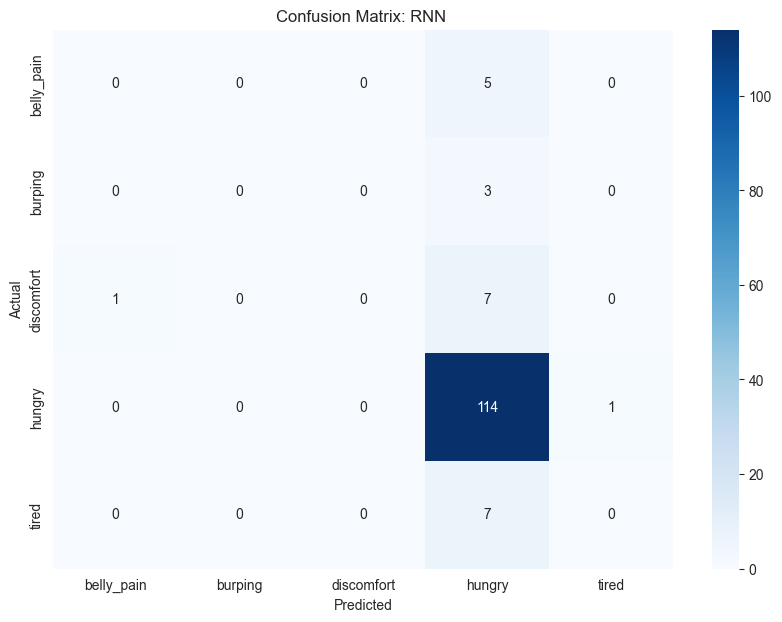

In [320]:
# Classification report
print(classification_report(y_test_rnn, y_pred_rnn, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_rnn, y_pred_rnn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: RNN ')
plt.show()

8. CNN

In [321]:
timesteps = 6 
n_features = X_mfcc_train.shape[1] // timesteps  # Adjust n_features

# Reshaping data for CNN
X_mfcc_train_cnn = X_mfcc_train.reshape((X_mfcc_train.shape[0], timesteps, n_features))
X_mfcc_test_cnn = X_mfcc_test.reshape((X_mfcc_test.shape[0], timesteps, n_features))

# Check the shapes
print("Training data shape:", X_mfcc_train_cnn.shape)
print("Testing data shape:", X_mfcc_test_cnn.shape)

Training data shape: (365, 6, 377)
Testing data shape: (92, 6, 377)


In [322]:
# One-hot encode labels
num_classes = len(np.unique(y_mfcc_train))
y_train_cnn = to_categorical(y_mfcc_train, num_classes)
y_test_cnn = to_categorical(y_mfcc_test, num_classes)



In [323]:
# CNN Model
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))




In [324]:
# Compile and Train the Model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_mfcc_train_cnn, y_train_cnn, epochs=20, batch_size=32, validation_split=0.2, verbose=2)


Epoch 1/20
10/10 - 2s - loss: 135.4934 - accuracy: 0.7260 - val_loss: 84.7514 - val_accuracy: 0.8082 - 2s/epoch - 164ms/step
Epoch 2/20
10/10 - 0s - loss: 48.9734 - accuracy: 0.6884 - val_loss: 36.7990 - val_accuracy: 0.8082 - 231ms/epoch - 23ms/step
Epoch 3/20
10/10 - 0s - loss: 19.8174 - accuracy: 0.7945 - val_loss: 26.5668 - val_accuracy: 0.8082 - 160ms/epoch - 16ms/step
Epoch 4/20
10/10 - 0s - loss: 15.0827 - accuracy: 0.7568 - val_loss: 15.3493 - val_accuracy: 0.8082 - 176ms/epoch - 18ms/step
Epoch 5/20
10/10 - 0s - loss: 12.4239 - accuracy: 0.6610 - val_loss: 21.2261 - val_accuracy: 0.8082 - 205ms/epoch - 20ms/step
Epoch 6/20
10/10 - 0s - loss: 12.0916 - accuracy: 0.8356 - val_loss: 14.6849 - val_accuracy: 0.8082 - 190ms/epoch - 19ms/step
Epoch 7/20
10/10 - 0s - loss: 6.5450 - accuracy: 0.7945 - val_loss: 9.2054 - val_accuracy: 0.7945 - 149ms/epoch - 15ms/step
Epoch 8/20
10/10 - 0s - loss: 5.3894 - accuracy: 0.8116 - val_loss: 12.3328 - val_accuracy: 0.8082 - 141ms/epoch - 14ms/s

In [325]:
# Make predictions on the test data
y_pred_cnn = cnn_model.predict(X_mfcc_test_cnn)
# Convert predictions and true labels from one-hot encoded format to class labels
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_true_classes_cnn = np.argmax(y_test_cnn, axis=1)


3/3 [==============================] - 0s 6ms/step


In [326]:
# Generate a classification report
print(classification_report(y_true_classes_cnn, y_pred_classes_cnn))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.00      0.00      0.00         2
           2       0.40      0.29      0.33         7
           3       0.82      0.97      0.89        72
           4       0.00      0.00      0.00         7

    accuracy                           0.79        92
   macro avg       0.44      0.30      0.33        92
weighted avg       0.72      0.79      0.74        92



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

In [327]:
# Accuracy
accuracy = accuracy_score(y_true_classes_cnn, y_pred_classes_cnn)

# F1 Score
f1 = f1_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

# Precision
precision = precision_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

# Recall
recall = recall_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [328]:
new_row_cv = pd.DataFrame([["CNN", accuracy , f1, precision,recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478


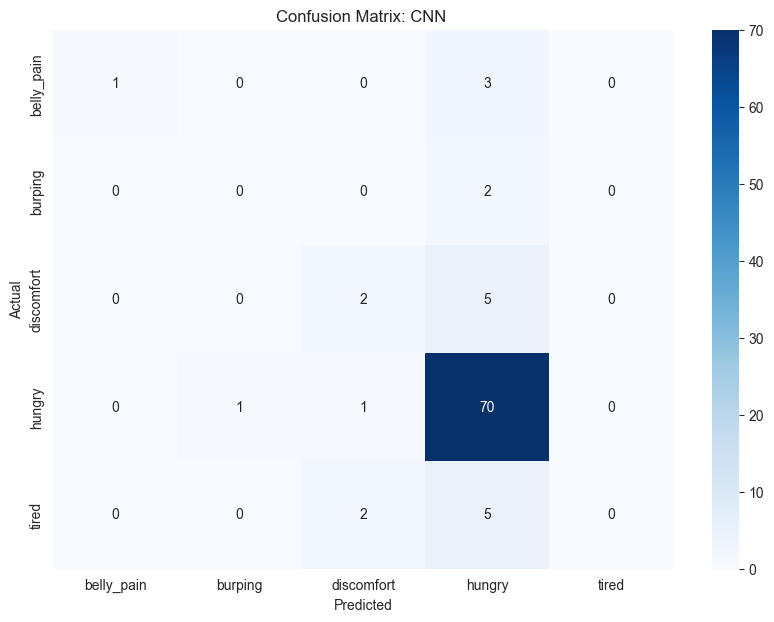

In [329]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes_cnn, y_pred_classes_cnn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: CNN ')
plt.show()

9. CNN-XGBoost

In [330]:
# Define the CNN model up to the Flatten layer
cnn_xg_model = Sequential()
cnn_xg_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_xg_model.add(MaxPooling1D(pool_size=2))
cnn_xg_model.add(Flatten())  # Feature extraction layer
cnn_xg_model.add(Dropout(0.5))

# Convert to a feature-extractor model that stops at the Flatten layer
feature_extractor = Model(inputs=cnn_xg_model.input, outputs=cnn_xg_model.layers[-2].output)

In [331]:
# Extract features from training and test data
X_train_features = feature_extractor.predict(X_mfcc_train_cnn)
X_test_features = feature_extractor.predict(X_mfcc_test_cnn)


3/3 [==============================] - 0s 5ms/step


In [332]:
'''# Initializing the XGBoost model
xgb_model_1 = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(xgb_model_1, X_train_features, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()
'''


"# Initializing the XGBoost model\nxgb_model_1 = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)\n# Apply 5-fold cross-validation and collect each metric's results\nresults = {}\nfor metric_name, metric in scoring_metrics.items():\n    scores = cross_val_score(xgb_model_1, X_train_features, y_mfcc_train, cv=5, scoring=metric)\n    results[metric_name] = scores.mean()\n"

In [333]:
'''# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["CNN-XGBoost (5-fold CV)", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df'''

'# Print the average cross-validation results for each metric\nfor metric_name, score in results.items():\n    print(f\'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}\')\n# Add the cross-validation results to the results dataframe\nnew_row_cv = pd.DataFrame([["CNN-XGBoost (5-fold CV)", results[\'accuracy\'], results[\'f1_weighted\'],\n                            results[\'precision_weighted\'], results[\'recall_weighted\']]],\n                          columns=[\'Model\', \'Accuracy\', \'F1 Score\', \'Precision\', \'Recall\'])\nresults_df = pd.concat([results_df, new_row_cv], ignore_index=True)\nresults_df'

In [334]:
# Initialize and train the XGBoost classifier
xgb_cnn_model = XGBClassifier(objective='multi:softmax', num_class=num_classes, eval_metric='mlogloss')
xgb_cnn_model.fit(X_train_features, y_mfcc_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [335]:
# Make predictions with XGBoost
y_pred_xgb_cnn = xgb_cnn_model.predict(X_test_features)

In [336]:
new_row_cv = pd.DataFrame([["CNN-XGBoost", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478


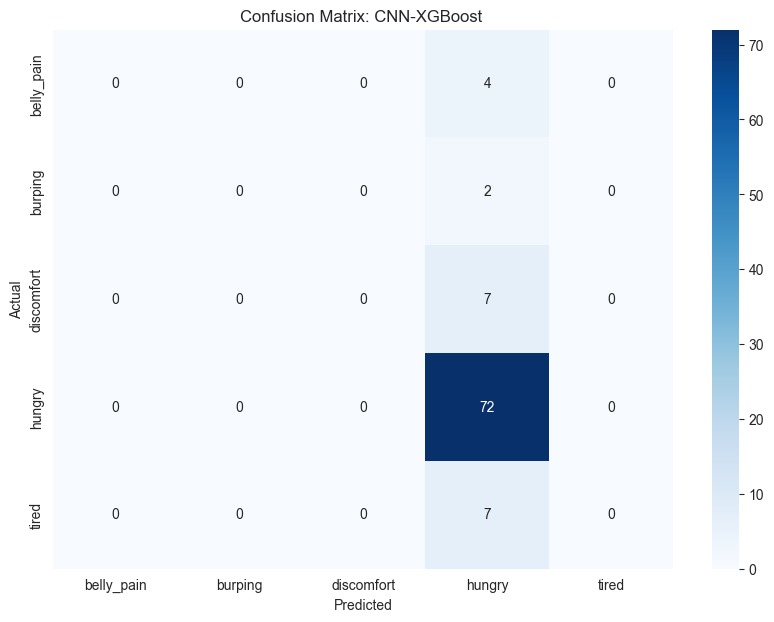

In [337]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_xgb_cnn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: CNN-XGBoost ')
plt.show()

10.CNN-LSTM

In [338]:
# CNN-LSTM Model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(64, activation='relu'))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(Dense(num_classes, activation='softmax'))

In [339]:
# Compile and Train the Model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_lstm_model.fit(X_mfcc_train_cnn, y_train_cnn, epochs=20, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/20
10/10 - 6s - loss: 14.9282 - accuracy: 0.3801 - val_loss: 21.5689 - val_accuracy: 0.4521 - 6s/epoch - 592ms/step
Epoch 2/20
10/10 - 0s - loss: 9.9701 - accuracy: 0.5993 - val_loss: 6.0078 - val_accuracy: 0.7945 - 139ms/epoch - 14ms/step
Epoch 3/20
10/10 - 0s - loss: 3.6839 - accuracy: 0.6678 - val_loss: 4.2302 - val_accuracy: 0.7808 - 139ms/epoch - 14ms/step
Epoch 4/20
10/10 - 0s - loss: 2.4625 - accuracy: 0.6815 - val_loss: 1.9397 - val_accuracy: 0.7534 - 148ms/epoch - 15ms/step
Epoch 5/20
10/10 - 0s - loss: 1.2123 - accuracy: 0.6438 - val_loss: 1.3820 - val_accuracy: 0.7808 - 144ms/epoch - 14ms/step
Epoch 6/20
10/10 - 0s - loss: 1.2635 - accuracy: 0.7432 - val_loss: 1.2434 - val_accuracy: 0.7808 - 142ms/epoch - 14ms/step
Epoch 7/20
10/10 - 0s - loss: 1.0201 - accuracy: 0.7979 - val_loss: 1.1933 - val_accuracy: 0.8082 - 146ms/epoch - 15ms/step
Epoch 8/20
10/10 - 0s - loss: 1.0570 - accuracy: 0.8356 - val_loss: 1.0328 - val_accuracy: 0.8082 - 159ms/epoch - 16ms/step
Epoch 9/

In [340]:
# Make predictions on the test data
y_pred_cnn_lstm = cnn_lstm_model.predict(X_mfcc_test_cnn)

# Convert predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred_cnn_lstm, axis=1)
y_true_classes = np.argmax(y_test_cnn, axis=1)


3/3 [==============================] - 0s 5ms/step


In [341]:
# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7826
F1 Score: 0.6872
Precision: 0.6125
Recall: 0.7826


D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [342]:
new_row_cv = pd.DataFrame([["CNN-LSTM", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


11. Ensemble learning

In [354]:
timesteps = 1
n_features = X_mfcc_train.shape[1] # Adjust n_features

# Reshaping data for CNN
X_mfcc_train_cnn = X_mfcc_train.reshape((X_mfcc_train.shape[0], timesteps, n_features))
X_mfcc_test_cnn = X_mfcc_test.reshape((X_mfcc_test.shape[0], timesteps, n_features))

# Check the shapes
print("Training data shape:", X_mfcc_train_cnn.shape)
print("Testing data shape:", X_mfcc_test_cnn.shape)

Training data shape: (365, 1, 2262)
Testing data shape: (92, 1, 2262)


In [355]:
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical if they are not already
num_classes = len(np.unique(y_mfcc_train))
y_mfcc_train_categorical = to_categorical(y_mfcc_train, num_classes=num_classes)

# Step 2: Define a CNN model for feature extraction
en_cnn_model = Sequential()
en_cnn_model.add(Conv1D(64, kernel_size=1, activation='relu', input_shape=(timesteps, n_features)))
en_cnn_model.add(MaxPooling1D(pool_size=1))
en_cnn_model.add(Flatten())
en_cnn_model.add(Dense(128, activation='relu'))  # Intermediate dense layer if needed
en_cnn_model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class

# Compile and train the CNN model
en_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
en_cnn_model.fit(X_mfcc_train_cnn, y_mfcc_train_categorical, epochs=20, batch_size=32, validation_split=0.2, verbose=2)


Epoch 1/20
10/10 - 1s - loss: 53.0867 - accuracy: 0.6849 - val_loss: 41.9818 - val_accuracy: 0.4521 - 1s/epoch - 105ms/step
Epoch 2/20
10/10 - 0s - loss: 27.2242 - accuracy: 0.7534 - val_loss: 43.0838 - val_accuracy: 0.8082 - 90ms/epoch - 9ms/step
Epoch 3/20
10/10 - 0s - loss: 20.7400 - accuracy: 0.7295 - val_loss: 20.4172 - val_accuracy: 0.8082 - 77ms/epoch - 8ms/step
Epoch 4/20
10/10 - 0s - loss: 12.7219 - accuracy: 0.8185 - val_loss: 9.0493 - val_accuracy: 0.7808 - 55ms/epoch - 5ms/step
Epoch 5/20
10/10 - 0s - loss: 4.6699 - accuracy: 0.7911 - val_loss: 10.5705 - val_accuracy: 0.3288 - 60ms/epoch - 6ms/step
Epoch 6/20
10/10 - 0s - loss: 4.2175 - accuracy: 0.7226 - val_loss: 8.5157 - val_accuracy: 0.7397 - 60ms/epoch - 6ms/step
Epoch 7/20
10/10 - 0s - loss: 4.1703 - accuracy: 0.8219 - val_loss: 9.6536 - val_accuracy: 0.5068 - 50ms/epoch - 5ms/step
Epoch 8/20
10/10 - 0s - loss: 2.9717 - accuracy: 0.8151 - val_loss: 8.9671 - val_accuracy: 0.3288 - 55ms/epoch - 5ms/step
Epoch 9/20
10/10

In [356]:

# Step 3: Extract CNN features
train_features = en_cnn_model.predict(X_mfcc_train_cnn)
test_features = en_cnn_model.predict(X_mfcc_test_cnn)

3/3 [==============================] - 0s 3ms/step


In [357]:
# Step 4: Define base classifiers and meta-classifier for stacking
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(kernel='linear', probability=True)),
    ('xgb', XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
]


In [358]:
y_mfcc_train.shape

(365,)

In [359]:
# Meta-classifier (KNN)
meta_learner = KNeighborsClassifier(n_neighbors=5)

# Step 5: Create a stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

# Train the stacking classifier
stacking_clf.fit(train_features, y_mfcc_train)

# Step 6: Make predictions with the stacking model
y_pred_stacking = stacking_clf.predict(test_features)



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:06:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:06:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Par

In [360]:
# Step 7: Evaluate the model
accuracy = accuracy_score(y_mfcc_test, y_pred_stacking)
f1 = f1_score(y_mfcc_test, y_pred_stacking, average='weighted')
precision = precision_score(y_mfcc_test, y_pred_stacking, average='weighted')
recall = recall_score(y_mfcc_test, y_pred_stacking, average='weighted')

print(f'Ensemble Accuracy: {accuracy * 100:.2f}%')
print(f'Ensemble F1 Score: {f1:.2f}')
print(f'Ensemble Precision: {precision:.2f}')
print(f'Ensemble Recall: {recall:.2f}')

Ensemble Accuracy: 72.83%
Ensemble F1 Score: 0.67
Ensemble Precision: 0.62
Ensemble Recall: 0.73


D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [361]:
new_row_cv = pd.DataFrame([["Ensemble Model(CNN,RandomForest,XGBoost,SVM,KNN)", accuracy , f1, precision,recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df



,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


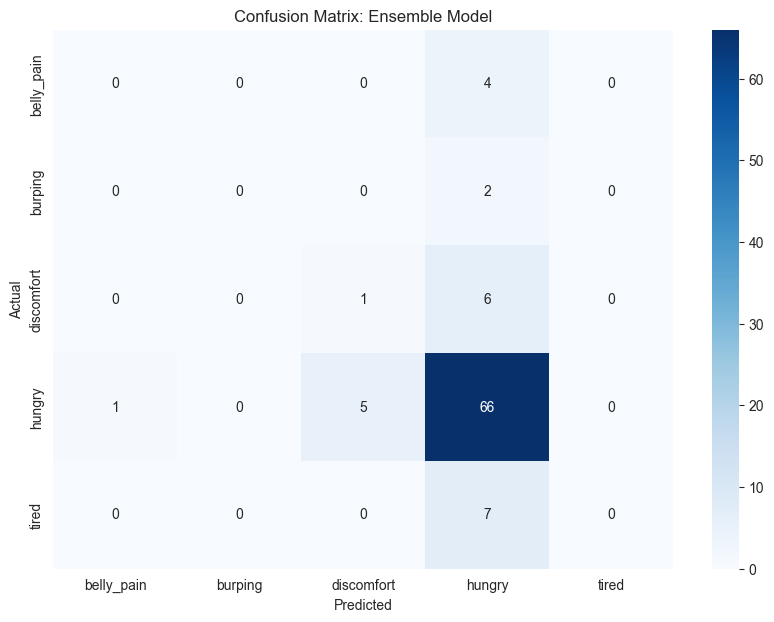

In [362]:
cm = confusion_matrix(y_mfcc_test, y_pred_stacking)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Ensemble Model')
plt.show()

## Handling Data imbalance with SMOTE

In [363]:
# the number of samples per class before applying SMOTE
print(f"Original class distribution: {Counter(y_mfcc_train)}")


Original class distribution: Counter({3: 310, 2: 20, 4: 17, 0: 12, 1: 6})


In [364]:
# Applying SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_mfcc_train, y_mfcc_train)

In [365]:
# the number of samples per class after oversampling
print(f"Class distribution after SMOTE: {Counter(y_train_resampled)}")

Class distribution after SMOTE: Counter({1: 310, 3: 310, 2: 310, 4: 310, 0: 310})


11. SVM with SMOTE

In [366]:
# Initializing the SVM model with SMOTE

svm_model_smote = SVC(kernel='linear', random_state=42)
# Define a list of scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted')
}


In [367]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(svm_model_smote, X_train_resampled, y_train_resampled, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')




5-Fold Cross-Validation Accuracy: 0.98
5-Fold Cross-Validation F1_weighted: 0.98
5-Fold Cross-Validation Precision_weighted: 0.98
5-Fold Cross-Validation Recall_weighted: 0.98


In [368]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["SVM (SMOTE on training data only)", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)




In [369]:
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [370]:
# Refit the model with the training data for confusion matrix and report
svm_model_smote.fit(X_train_resampled, y_train_resampled)
# Making predictions
y_pred_smote = svm_model_smote.predict(X_mfcc_test)
# Print classification report
print(classification_report(y_mfcc_test, y_pred_smote, target_names=class_labels))


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.25      0.14      0.18         7
      hungry       0.81      0.85      0.83        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.67        92
   macro avg       0.21      0.20      0.20        92
weighted avg       0.66      0.67      0.66        92



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

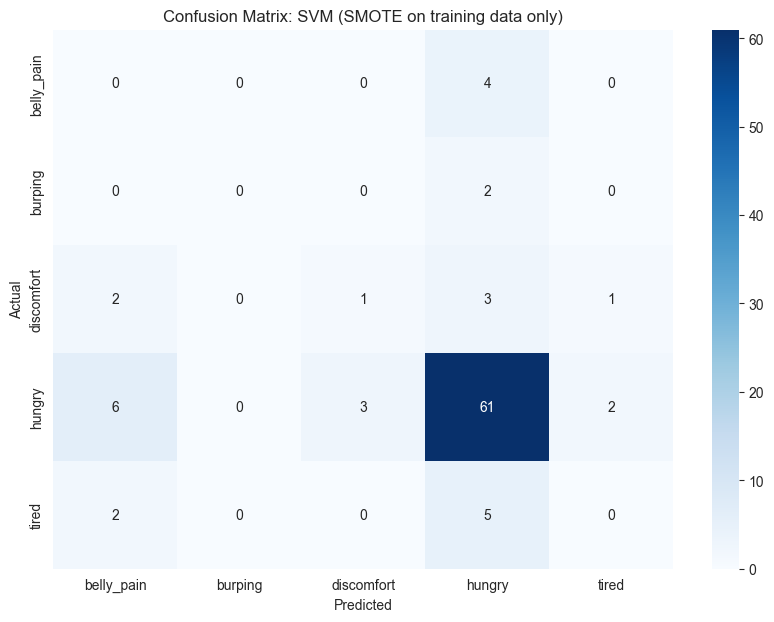

In [371]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_smote)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: SVM (SMOTE on training data only)')
plt.show()

12. KNN with SMOTE

In [372]:
# Step 1: Initialize the KNN model
knn_model_smote = KNeighborsClassifier(n_neighbors=5) 

In [373]:
# Step 2: Applying 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(knn_model_smote,X_train_resampled, y_train_resampled, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

In [374]:
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 0.84
5-Fold Cross-Validation F1_weighted: 0.80
5-Fold Cross-Validation Precision_weighted: 0.87
5-Fold Cross-Validation Recall_weighted: 0.84


In [375]:
# Step 3: Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["KNN (SMOTE on training data only)", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [376]:
# Refit the model with the training data for confusion matrix and report
knn_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_knn_smote = knn_model_smote.predict(X_mfcc_test)

In [377]:
# Print classification report
print(classification_report(y_mfcc_test, y_pred_knn_smote, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.05      0.25      0.08         4
     burping       0.11      0.50      0.18         2
  discomfort       0.10      0.29      0.15         7
      hungry       0.78      0.25      0.38        72
       tired       0.10      0.29      0.15         7

    accuracy                           0.26        92
   macro avg       0.23      0.31      0.19        92
weighted avg       0.63      0.26      0.33        92



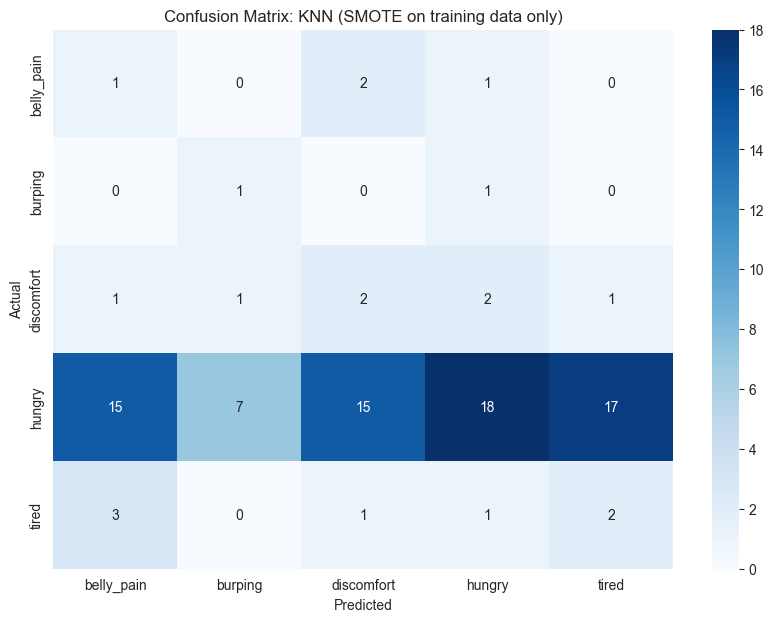

In [378]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_knn_smote)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: KNN (SMOTE on training data only)')
plt.show()

13. Random Forest (SMOTE on training data only)

In [379]:
# Random Forest with SMOTE
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)

In [380]:
# Step 2: Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(rf_model_smote ,X_train_resampled, y_train_resampled, cv=5, scoring=metric)
    results[metric_name] = scores.mean()
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 1.00
5-Fold Cross-Validation F1_weighted: 1.00
5-Fold Cross-Validation Precision_weighted: 1.00
5-Fold Cross-Validation Recall_weighted: 1.00


In [381]:
# Step 3: Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["Random Forest (SMOTE on training data only)", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [382]:
# Refit the model with the training data for confusion matrix and report
rf_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_rf_smote = rf_model_smote.predict(X_mfcc_test)

# Print classification report
print(classification_report(y_mfcc_test, y_pred_rf_smote, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.79      0.99      0.88        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.77        92
   macro avg       0.16      0.20      0.18        92
weighted avg       0.62      0.77      0.69        92



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

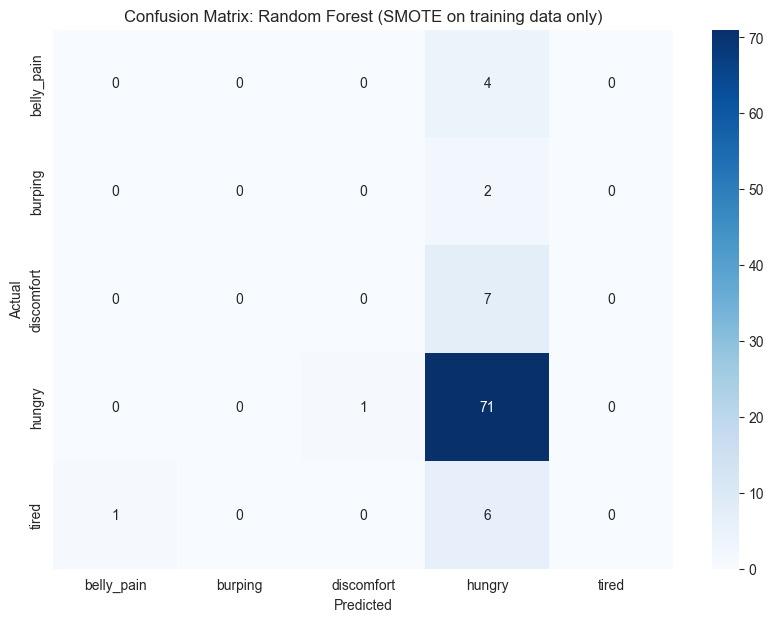

In [383]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_rf_smote)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Random Forest (SMOTE on training data only)')
plt.show()

15. AdaBoost model

In [384]:
# Initializing the AdaBoost model with SMOTE
ada_model_smote = AdaBoostClassifier(n_estimators=100, random_state=42)

In [385]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(ada_model_smote, X_train_resampled, y_train_resampled, cv=5, scoring=metric)
    results[metric_name] = scores.mean()
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

5-Fold Cross-Validation Accuracy: 0.29
5-Fold Cross-Validation F1_weighted: 0.21
5-Fold Cross-Validation Precision_weighted: 0.26
5-Fold Cross-Validation Recall_weighted: 0.29


In [386]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["AdaBoost (SMOTE on training data only)", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [387]:
# Refit the model with the training data for confusion matrix and report
ada_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_ada_smote = ada_model_smote.predict(X_mfcc_test)

In [388]:
# Print classification report
print(classification_report(y_mfcc_test, y_pred_ada_smote, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.04      0.75      0.08         4
     burping       0.00      0.00      0.00         2
  discomfort       0.12      0.29      0.17         7
      hungry       0.00      0.00      0.00        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.05        92
   macro avg       0.03      0.21      0.05        92
weighted avg       0.01      0.05      0.02        92



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

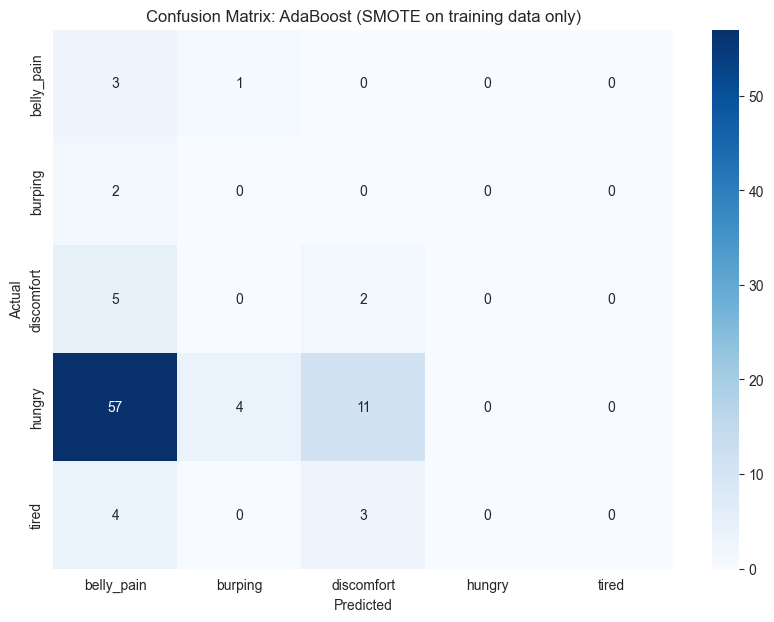

In [389]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_ada_smote)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: AdaBoost (SMOTE on training data only)')
plt.show()

16.XGBoost Model

In [390]:
# Initializing the XGBoost model
xgb_model_smote = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [391]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(xgb_model_smote, X_train_resampled, y_train_resampled, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Par

5-Fold Cross-Validation Accuracy: 0.99
5-Fold Cross-Validation F1_weighted: 0.99
5-Fold Cross-Validation Precision_weighted: 0.99
5-Fold Cross-Validation Recall_weighted: 0.99


In [392]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["XGBoost (SMOTE on training data only)", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [393]:
# Refit the model with the training data for confusion matrix and report
xgb_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_xgb_smote = xgb_model_smote.predict(X_mfcc_test)

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [394]:
# Print classification report
print(classification_report(y_mfcc_test, y_pred_xgb_smote, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      0.97      0.86        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.76        92
   macro avg       0.16      0.19      0.17        92
weighted avg       0.61      0.76      0.68        92



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

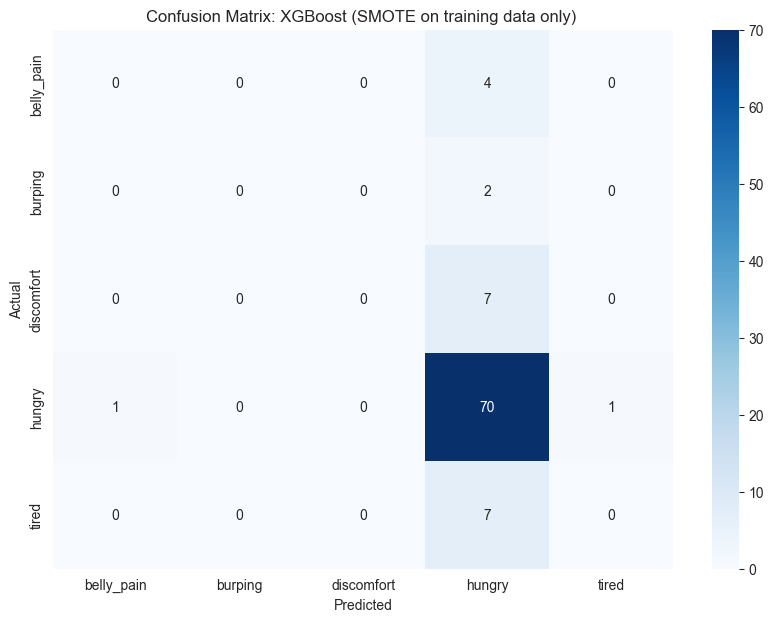

In [395]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_xgb_smote)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: XGBoost (SMOTE on training data only) ')
plt.show()

17. LSTM with SMOTE

In [396]:
# Flatten the training data for SMOTE
timesteps = X_train_lstm.shape[1]  # 174
features = X_train_lstm.shape[2]   # 13
X_train_lstm_flat = X_train_lstm.reshape(X_train_lstm.shape[0], timesteps * features)  # Shape: (samples, timesteps * features)

In [397]:
y_train_lstm.shape

(319, 5)

In [398]:
# Apply SMOTE
smote = SMOTE(random_state=42,k_neighbors=1)
X_train_lstm_resampled, y_train_lstm_resampled = smote.fit_resample(X_train_lstm_flat, y_train_lstm )

In [399]:
y_train_lstm.shape

(319, 5)

In [400]:
# the number of samples per class before applying SMOTE
y_train_1d = np.argmax(y_train_lstm, axis=1)
print(f"Original class distribution before SMOTE: {Counter(y_train_1d)}")

# the number of samples per class after applying SMOTE
y_train_1d=np.argmax(y_train_lstm_resampled, axis=1)
print(f"Original class distribution after SMOTE: {Counter(y_train_1d)}")


Original class distribution before SMOTE: Counter({3: 267, 2: 19, 4: 17, 0: 11, 1: 5})
Original class distribution after SMOTE: Counter({3: 267, 2: 267, 0: 267, 1: 267, 4: 267})


In [401]:
y_train_1d.shape

(1335,)

In [402]:
X_train_lstm_resampled.shape

(1335, 2262)

In [403]:
# Reshape back to 3D for LSTM
X_train_resampled_lstm = X_train_lstm_resampled.reshape(X_train_lstm_resampled.shape[0], timesteps, features)


In [404]:
# Check label shapes
print("y_train_resampled_lstm shape:", y_train_lstm_resampled.shape)  
print("y_test_lstm shape:", y_test_lstm.shape)  

y_train_resampled_lstm shape: (1335, 5)
y_test_lstm shape: (138, 5)


In [405]:
lstm_model = Sequential()
# Add LSTM layer
lstm_model.add(LSTM(128, input_shape=(X_train_resampled_lstm.shape[1], X_train_resampled_lstm.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.3))
# Add another LSTM layer, ensure it doesn't return sequences
lstm_model.add(LSTM(64, return_sequences=False))  # Final LSTM layer does not return sequences
lstm_model.add(Dropout(0.3))
# Add Dense layers
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.3))
# Output layer with softmax for multi-class classification
lstm_model.add(Dense(len(class_labels), activation='softmax'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [406]:
# Train the model
history = lstm_model.fit(
    X_train_resampled_lstm, y_train_lstm_resampled,
    epochs=50, batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm)
)

Epoch 1/50
42/42 [==============================] - 15s 275ms/step - loss: 1.4562 - accuracy: 0.3918 - val_loss: 1.6065 - val_accuracy: 0.2391
Epoch 2/50
42/42 [==============================] - 11s 262ms/step - loss: 0.8828 - accuracy: 0.6944 - val_loss: 1.1548 - val_accuracy: 0.5362
Epoch 3/50
42/42 [==============================] - 11s 254ms/step - loss: 0.5197 - accuracy: 0.8195 - val_loss: 1.1928 - val_accuracy: 0.6014
Epoch 4/50
42/42 [==============================] - 12s 272ms/step - loss: 0.3084 - accuracy: 0.9041 - val_loss: 1.0604 - val_accuracy: 0.7536
Epoch 5/50
42/42 [==============================] - 10s 245ms/step - loss: 0.2100 - accuracy: 0.9386 - val_loss: 1.0160 - val_accuracy: 0.7464
Epoch 6/50
42/42 [==============================] - 10s 244ms/step - loss: 0.1729 - accuracy: 0.9536 - val_loss: 1.1602 - val_accuracy: 0.7174
Epoch 7/50
42/42 [==============================] - 11s 265ms/step - loss: 0.1034 - accuracy: 0.9723 - val_loss: 1.2395 - val_accuracy: 0.7971

In [407]:
# Evaluate the model
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
y_test_lstm_ = np.argmax(y_test_lstm, axis=1)

5/5 [==============================] - 1s 66ms/step


In [408]:
#Evaluation Model
accuracy = accuracy_score(y_test_lstm_, y_pred_lstm)
f1 = f1_score(y_test_lstm_, y_pred_lstm, average='weighted')
precision = precision_score(y_test_lstm_, y_pred_lstm, average='weighted')
recall = recall_score(y_test_lstm_, y_pred_lstm, average='weighted')


D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [409]:
new_row_cv = pd.DataFrame([["LSTM with SMOTE", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [410]:
# Classification report
print(classification_report(y_test_lstm_, y_pred_lstm, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.17      0.20      0.18         5
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         8
      hungry       0.84      0.90      0.87       115
       tired       0.00      0.00      0.00         7

    accuracy                           0.75       138
   macro avg       0.20      0.22      0.21       138
weighted avg       0.71      0.75      0.73       138



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

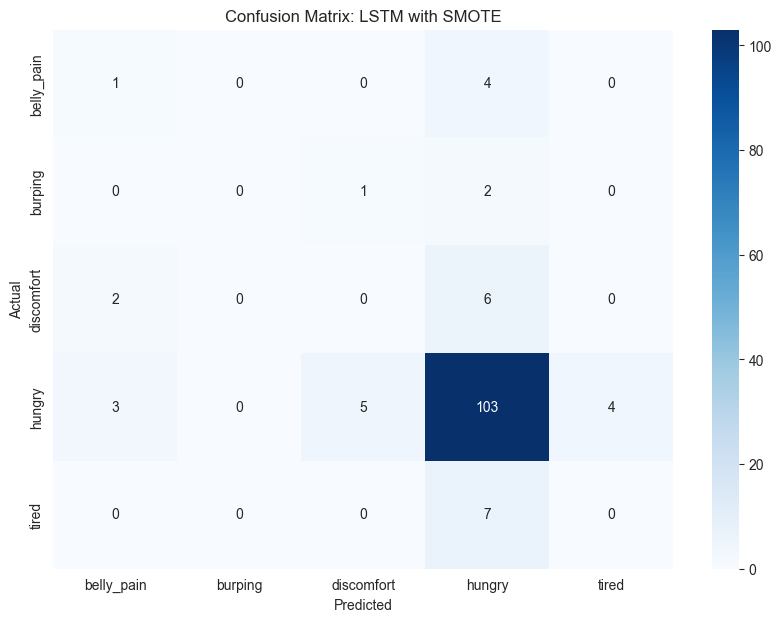

In [411]:

# Confusion Matrix
cm = confusion_matrix(y_test_lstm_, y_pred_lstm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: LSTM with SMOTE')
plt.show()

18. RNN with SMOTE

In [412]:
# Define the RNN model
rnn_model_smote = Sequential()

In [413]:
# Add SimpleRNN layer
rnn_model_smote.add(SimpleRNN(128, input_shape=(X_train_resampled_lstm.shape[1], X_train_resampled_lstm.shape[2]), return_sequences=True))
rnn_model_smote.add(Dropout(0.3))
# Add another SimpleRNN layer
rnn_model_smote.add(SimpleRNN(64, return_sequences=False))
rnn_model_smote.add(Dropout(0.3))

# Add Dense layers
rnn_model_smote.add(Dense(32, activation='relu'))
rnn_model_smote.add(Dropout(0.3))
# Output layer with softmax for multi-class classification
rnn_model_smote.add(Dense(len(class_labels), activation='softmax'))
# Compile the model
rnn_model_smote.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [414]:
# Train the model
history = rnn_model_smote.fit(X_train_resampled_lstm, y_train_lstm_resampled, epochs=50, batch_size=32,
                        validation_data=(X_test_lstm, y_test_lstm))


Epoch 1/50
42/42 [==============================] - 8s 91ms/step - loss: 1.5046 - accuracy: 0.3491 - val_loss: 1.6585 - val_accuracy: 0.1449
Epoch 2/50
42/42 [==============================] - 4s 92ms/step - loss: 1.1019 - accuracy: 0.5618 - val_loss: 1.6903 - val_accuracy: 0.1522
Epoch 3/50
42/42 [==============================] - 4s 87ms/step - loss: 0.8621 - accuracy: 0.6809 - val_loss: 1.6052 - val_accuracy: 0.2174
Epoch 4/50
42/42 [==============================] - 4s 85ms/step - loss: 0.6855 - accuracy: 0.7468 - val_loss: 1.5474 - val_accuracy: 0.2899
Epoch 5/50
42/42 [==============================] - 4s 95ms/step - loss: 0.5605 - accuracy: 0.7813 - val_loss: 1.4734 - val_accuracy: 0.3406
Epoch 6/50
42/42 [==============================] - 4s 85ms/step - loss: 0.5028 - accuracy: 0.8105 - val_loss: 1.4726 - val_accuracy: 0.3913
Epoch 7/50
42/42 [==============================] - 3s 83ms/step - loss: 0.4144 - accuracy: 0.8524 - val_loss: 1.3536 - val_accuracy: 0.4493
Epoch 8/50
42

In [415]:
# Evaluate the model
y_pred_rnn_s = np.argmax(rnn_model_smote.predict(X_test_lstm), axis=1)
y_test_rnn_s = np.argmax(y_test_lstm, axis=1)

5/5 [==============================] - 0s 22ms/step


In [416]:
# Accuracy
accuracy = accuracy_score(y_test_rnn_s, y_pred_rnn_s)
f1 = f1_score(y_test_rnn_s, y_pred_rnn_s, average='weighted')
precision = precision_score(y_test_rnn_s, y_pred_rnn_s, average='weighted')
recall = recall_score(y_test_rnn_s, y_pred_rnn_s, average='weighted')

new_row_cv = pd.DataFrame([["RNN with SMOTE", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [417]:
# Classification report
print(classification_report(y_test_rnn_s, y_pred_rnn_s, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         5
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         8
      hungry       0.82      0.86      0.84       115
       tired       0.00      0.00      0.00         7

    accuracy                           0.72       138
   macro avg       0.16      0.17      0.17       138
weighted avg       0.69      0.72      0.70       138



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

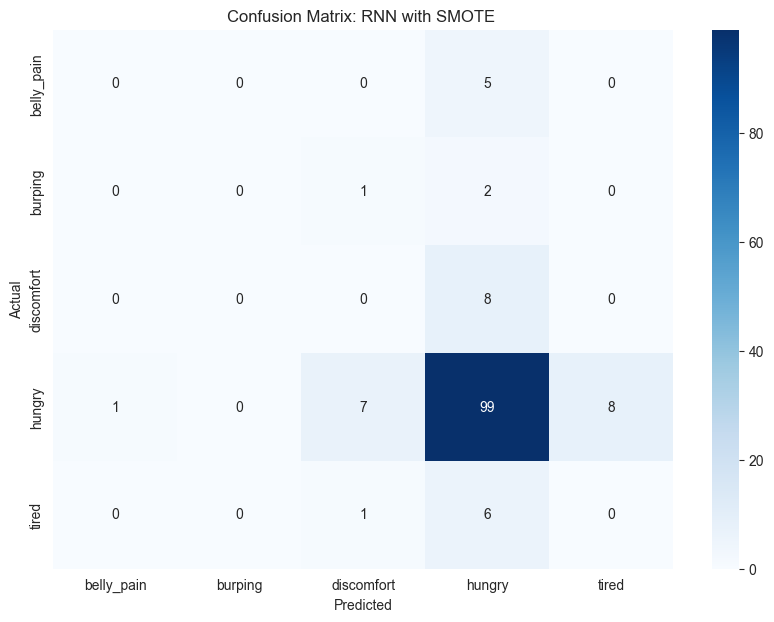

In [418]:
# Confusion Matrix
cm = confusion_matrix(y_test_rnn_s, y_pred_rnn_s)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: RNN with SMOTE ')
plt.show()

19. CNN with SMOTE

In [431]:
timesteps = 6
n_features = X_train_resampled.shape[1] // timesteps  # Adjust n_features


In [441]:
# Reshape the resampled data for CNN
X_train_resampled_cnn = X_train_resampled.reshape((X_train_resampled.shape[0], timesteps, n_features))
X_mfcc_test_cnn = X_mfcc_test.reshape((X_mfcc_test.shape[0], timesteps, n_features))
# Check the shape
print("Resampled training data shape:", X_train_resampled_cnn.shape)
print("Resampled testing data shape:",X_mfcc_test_cnn.shape)


Resampled training data shape: (1550, 6, 377)
Resampled testing data shape: (92, 6, 377)


In [433]:
# One-hot encode resampled labels
y_train_resampled_cnn = to_categorical(y_train_resampled, num_classes=len(class_labels))


In [434]:
y_train_resampled_cnn.shape

(1550, 5)

In [435]:
# CNN Model
cnn_model_s = Sequential()
cnn_model_s.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_model_s.add(MaxPooling1D(pool_size=2))
cnn_model_s.add(Flatten())
cnn_model_s.add(Dropout(0.5))
cnn_model_s.add(Dense(len(class_labels), activation='softmax'))

In [436]:
# Compile the model (if not already compiled)
cnn_model_s.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model with the resampled data
cnn_model_s.fit(X_train_resampled_cnn, y_train_resampled_cnn, epochs=20, batch_size=32, validation_split=0.2, verbose=2)


Epoch 1/20
39/39 - 1s - loss: 60.4578 - accuracy: 0.4306 - val_loss: 83.5135 - val_accuracy: 0.0484 - 1s/epoch - 29ms/step
Epoch 2/20
39/39 - 0s - loss: 4.9339 - accuracy: 0.6774 - val_loss: 25.5176 - val_accuracy: 0.0968 - 175ms/epoch - 4ms/step
Epoch 3/20
39/39 - 0s - loss: 2.1234 - accuracy: 0.7565 - val_loss: 21.0309 - val_accuracy: 0.0677 - 270ms/epoch - 7ms/step
Epoch 4/20
39/39 - 0s - loss: 1.6363 - accuracy: 0.7815 - val_loss: 12.7716 - val_accuracy: 0.0581 - 167ms/epoch - 4ms/step
Epoch 5/20
39/39 - 0s - loss: 1.1445 - accuracy: 0.8073 - val_loss: 10.7145 - val_accuracy: 0.1097 - 164ms/epoch - 4ms/step
Epoch 6/20
39/39 - 0s - loss: 0.9443 - accuracy: 0.8226 - val_loss: 9.1577 - val_accuracy: 0.1548 - 262ms/epoch - 7ms/step
Epoch 7/20
39/39 - 0s - loss: 0.7850 - accuracy: 0.8476 - val_loss: 4.4122 - val_accuracy: 0.2806 - 164ms/epoch - 4ms/step
Epoch 8/20
39/39 - 0s - loss: 0.6996 - accuracy: 0.8532 - val_loss: 11.1708 - val_accuracy: 0.1129 - 147ms/epoch - 4ms/step
Epoch 9/20


In [442]:
X_mfcc_test_cnn.shape

(92, 6, 377)

In [443]:
# Make predictions on the test data
y_pred_cnn = cnn_model_s.predict(X_mfcc_test_cnn)
# Convert predictions and true labels from one-hot encoded format to class labels
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_true_classes_cnn = np.argmax(y_test_cnn, axis=1)

3/3 [==============================] - 0s 3ms/step


In [444]:
# Generate a classification report
print(classification_report(y_true_classes_cnn, y_pred_classes_cnn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         2
           2       0.33      0.14      0.20         7
           3       0.78      0.86      0.82        72
           4       0.00      0.00      0.00         7

    accuracy                           0.68        92
   macro avg       0.22      0.20      0.20        92
weighted avg       0.64      0.68      0.66        92



In [445]:
# Accuracy
accuracy = accuracy_score(y_true_classes_cnn, y_pred_classes_cnn)

# F1 Score
f1 = f1_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

# Precision
precision = precision_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

# Recall
recall = recall_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

new_row_cv = pd.DataFrame([["CNN with SMOTE", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


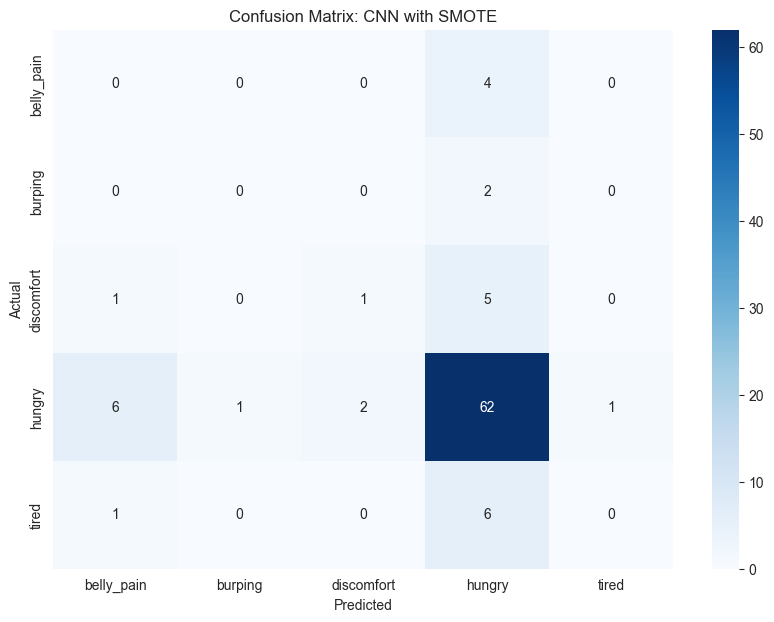

In [446]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes_cnn, y_pred_classes_cnn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: CNN with SMOTE')
plt.show()

20. CNN-XGBoost with SMOTE

In [447]:
# Define the CNN model up to the Flatten layer
cnn_xg_model = Sequential()
cnn_xg_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_xg_model.add(MaxPooling1D(pool_size=2))
cnn_xg_model.add(Flatten())  # Feature extraction layer
cnn_xg_model.add(Dropout(0.5))

In [448]:
# Convert to a feature-extractor model that stops at the Flatten layer
feature_extractor = Model(inputs=cnn_xg_model.input, outputs=cnn_xg_model.layers[-2].output)

In [449]:
# Extract features from training and test data
X_train_features = feature_extractor.predict(X_train_resampled_cnn)
X_test_features = feature_extractor.predict(X_mfcc_test_cnn)

3/3 [==============================] - 0s 3ms/step


In [450]:
xgb_model_1 = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(xgb_model_1, X_train_features, y_train_resampled, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Par

In [451]:
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 0.98
5-Fold Cross-Validation F1_weighted: 0.98
5-Fold Cross-Validation Precision_weighted: 0.98
5-Fold Cross-Validation Recall_weighted: 0.98


In [452]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["CNN-XGBoost with SMOTE", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [453]:
# Refit the model with the training data for confusion matrix and report
xgb_model_1.fit(X_train_features, y_train_resampled)
y_pred_xgb = xgb_model_1.predict(X_test_features)

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:01:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [454]:
# Print classification report
print(classification_report(y_mfcc_test, y_pred_xgb, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.67      0.29      0.40         7
      hungry       0.80      0.93      0.86        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.75        92
   macro avg       0.29      0.24      0.25        92
weighted avg       0.67      0.75      0.70        92



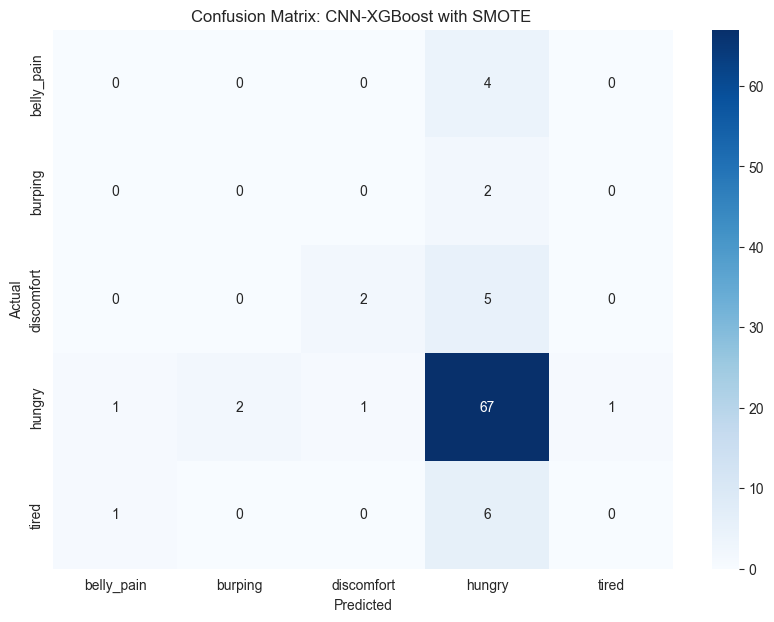

In [455]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_xgb)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: CNN-XGBoost with SMOTE ')
plt.show()

21. CNN-LSTM with SMOTE

In [456]:
# CNN-LSTM Model with SMOTE
cnn_lstm_model_s = Sequential()
cnn_lstm_model_s.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_lstm_model_s.add(MaxPooling1D(pool_size=2))
cnn_lstm_model_s.add(LSTM(64, activation='relu'))
cnn_lstm_model_s.add(Dropout(0.5))
cnn_lstm_model_s.add(Dense(num_classes, activation='softmax'))
# Compile and Train the Model
cnn_lstm_model_s.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_lstm_model_s.fit(X_train_resampled_cnn, y_train_resampled_cnn, epochs=20, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/20
39/39 - 2s - loss: 10.7595 - accuracy: 0.2556 - val_loss: 3.8615 - val_accuracy: 0.0032 - 2s/epoch - 41ms/step
Epoch 2/20
39/39 - 0s - loss: 1.8349 - accuracy: 0.4121 - val_loss: 3.0292 - val_accuracy: 0.0226 - 173ms/epoch - 4ms/step
Epoch 3/20
39/39 - 0s - loss: 1.4000 - accuracy: 0.3960 - val_loss: 2.3801 - val_accuracy: 0.0065 - 224ms/epoch - 6ms/step
Epoch 4/20
39/39 - 0s - loss: 1.2450 - accuracy: 0.4379 - val_loss: 3.6191 - val_accuracy: 0.0000e+00 - 215ms/epoch - 6ms/step
Epoch 5/20
39/39 - 0s - loss: 1.2487 - accuracy: 0.4766 - val_loss: 2.6330 - val_accuracy: 0.0355 - 171ms/epoch - 4ms/step
Epoch 6/20
39/39 - 0s - loss: 1.2744 - accuracy: 0.4718 - val_loss: 2.6374 - val_accuracy: 0.0452 - 209ms/epoch - 5ms/step
Epoch 7/20
39/39 - 0s - loss: 1.2168 - accuracy: 0.4831 - val_loss: 3.1640 - val_accuracy: 0.0387 - 180ms/epoch - 5ms/step
Epoch 8/20
39/39 - 0s - loss: 1.2377 - accuracy: 0.4863 - val_loss: 1.8684 - val_accuracy: 0.0516 - 160ms/epoch - 4ms/step
Epoch 9/20
39

In [457]:
# Make predictions on the test data
y_pred_cnn_lstm = cnn_lstm_model_s.predict(X_mfcc_test_cnn)

# Convert predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred_cnn_lstm, axis=1)
y_true_classes = np.argmax(y_test_cnn, axis=1)

3/3 [==============================] - 0s 0s/step


In [458]:
# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

new_row_cv = pd.DataFrame([["CNN-LSTM with SMOTE", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


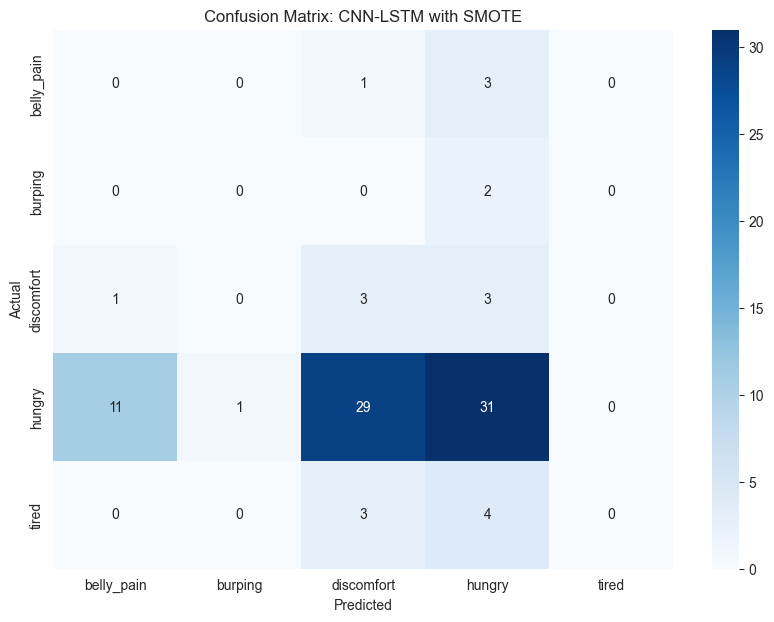

In [459]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: CNN-LSTM with SMOTE')
plt.show()

22. Ensemble Model with SMOTE

In [460]:
# Extracting features using already trained CNN model with SMOTE  
train_features = cnn_model_s.predict(X_train_resampled_cnn)  
test_features = cnn_model_s.predict(X_mfcc_test_cnn)

3/3 [==============================] - 0s 3ms/step


In [461]:
# Define base classifiers and meta-classifier for stacking
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(kernel='linear', probability=True)),
    ('xgb',
     XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
]

In [462]:
# Meta-classifier (KNN)
meta_learner = KNeighborsClassifier(n_neighbors=5)  # RandomForestClassifier(n_estimators=100, random_state=42) 

In [463]:
#  Create a stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

In [464]:
train_features.shape

(1550, 5)

In [465]:
y_train_resampled_cnn.shape

(1550, 5)

In [466]:
# the number of samples per class after applying SMOTE
y_train_1d=np.argmax(y_train_resampled_cnn, axis=1)
y_train_1d.shape

(1550,)

In [467]:
# Train the stacking classifier
stacking_clf.fit(train_features, y_train_1d)

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:03:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:03:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:03:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Par

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svm', SVC(kernel='linear', probability=True)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              fe...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=KNeighborsClassifier())

In [468]:
#   Make predictions with the stacking model
y_pred_stacking = stacking_clf.predict(test_features)

In [469]:
y_mfcc_test.shape

(92,)

In [470]:
test_features.shape

(92, 5)

In [471]:
# Step 7: Evaluate the model
accuracy = accuracy_score(y_mfcc_test, y_pred_stacking)
f1 = f1_score(y_mfcc_test, y_pred_stacking, average='weighted')
precision = precision_score(y_mfcc_test, y_pred_stacking, average='weighted')
recall = recall_score(y_mfcc_test, y_pred_stacking, average='weighted')

print(f'Ensemble Accuracy: {accuracy * 100:.2f}%')
print(f'Ensemble F1 Score: {f1:.2f}')
print(f'Ensemble Precision: {precision:.2f}')
print(f'Ensemble Recall: {recall:.2f}')
new_row_cv = pd.DataFrame([["Ensemble Model(CNN,RandomForest, XGBoost, SVM,KNN) with SMOTE", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df


Ensemble Accuracy: 70.65%
Ensemble F1 Score: 0.68
Ensemble Precision: 0.68
Ensemble Recall: 0.71


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.789855,0.741497,0.698718,0.789855
6,RNN,0.826087,0.756972,0.698529,0.826087
7,CNN,0.793478,0.740621,0.718414,0.793478
8,CNN-XGBoost,0.793478,0.740621,0.718414,0.793478
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


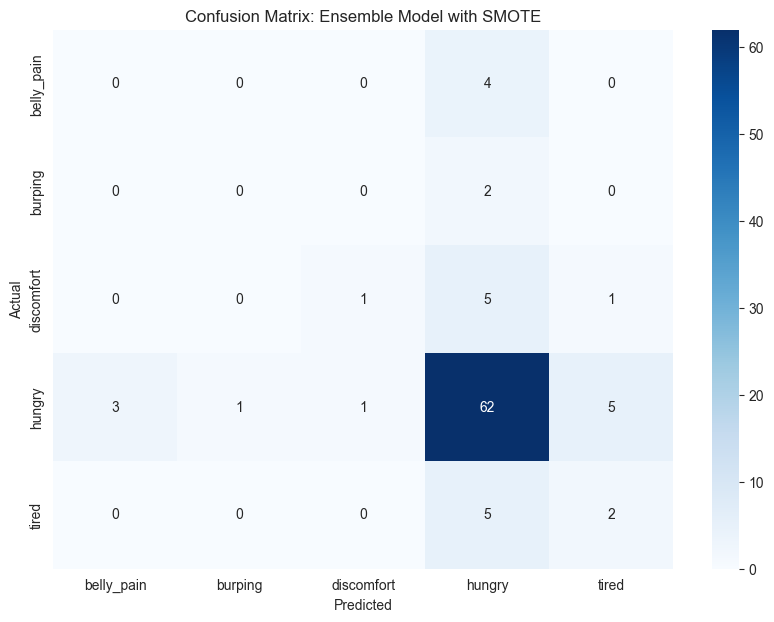

In [472]:
cm = confusion_matrix(y_mfcc_test, y_pred_stacking)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Ensemble Model with SMOTE')
plt.show()